In [1]:
import numpy as np
from PIL import Image

In [2]:
P = 7 # Patch size
factor, N = 2, 2 # Resizing factor, steps in pyramid
alpha = 5 * 0.0001 # Value is not clear, inf 
T = 10 # Number of iterations in each level, T = 1 in coarsest level

In [3]:
from numpy.lib.stride_tricks import as_strided

def get_image_patches(image, patch_size):
    assert len(image.shape) == 3, "Image should have dimensions (width, height, channel)."
    assert image.shape[2] == 3, "Image should have 3 channels."

    stride_w = image.strides[0]  # stride of width
    stride_h = image.strides[1]  # stride of height
    stride_c = image.strides[2]  # stride of channel

    width, height, _ = image.shape
    patch_width, patch_height = patch_size, patch_size

    assert width >= patch_width, "Patch size should be less than or equal to image width."
    assert height >= patch_height, "Patch size should be less than or equal to image height."

    num_patches_w = width - patch_width + 1
    num_patches_h = height - patch_height + 1

    patches = as_strided(image, shape=(num_patches_w, num_patches_h, patch_width, patch_height, 3),
                         strides=(stride_w, stride_h, stride_w, stride_h, stride_c))

    return patches

In [4]:
def compute_distance_between_images(list1, list2, alpha):
    assert len(list1.shape) == 4, "Images should have dimensions (num_images, height, width, channels)."
    assert len(list2.shape) == 4, "Images should have dimensions (num_images, height, width, channels)."

    num_images1, height1, width1, channels1 = list1.shape
    num_images2, height2, width2, channels2 = list2.shape

    assert height1 == height2 and width1 == width2 and channels1 == channels2, \
        "Images in both lists should have the same dimensions."

    mse_values = np.zeros((num_images1, num_images2))

    for i in range(num_images1):
        for j in range(num_images2):
            mse = np.mean((list1[i] - list2[j]) ** 2)
            mse_values[i, j] = mse

    mse_values = mse_values / ((np.min(mse_values, axis=1))[:, np.newaxis] + alpha)

    return mse_values

In [5]:
image = Image.open('people_on_the_beach.jpg')
C = len(image.getbands())
image_arr = np.asarray(image)
image_arr.shape

(167, 250, 3)

In [6]:
patches = get_image_patches(image_arr, P)  # Divide the image into (10, 10, 3) patches

In [7]:
patches.shape

(161, 244, 7, 7, 3)

In [8]:
# list of smaller images
smaller_image_arrs = [np.asarray(image.resize((int(image.size[0]/(i * factor)), int(image.size[1]/(i * factor))))) for i in range(1, N+1)]
smaller_image_arrs.insert(0, np.asarray(image))
[i.shape for i in smaller_image_arrs]

[(167, 250, 3), (83, 125, 3), (41, 62, 3)]

In [18]:
#Nth step (coarsest scale)
noise = np.random.normal(size=smaller_image_arrs[-1].shape)
Q = smaller_image_arrs[-1] + noise # y_n+1
Q = get_image_patches(Q, P)
Q = Q.reshape(-1, P, P, C)
V = smaller_image_arrs[-1] # x_n
V = get_image_patches(V, P)
V_shape = V.shape
V = V.reshape(-1, P, P, C)
K = smaller_image_arrs[-1] # x_n+1
K = get_image_patches(K, P)
K = K.reshape(-1, P, P, C)

Q.shape, K.shape, V.shape

((1960, 7, 7, 3), (1960, 7, 7, 3), (1960, 7, 7, 3))

In [11]:
Image.fromarray(K[0, 0])

In [12]:
K = K.reshape(-1, P, P, C)
Image.fromarray(K[0])

In [12]:
distances = compute_distance_between_images(Q, K, alpha)

In [13]:
nearest_neighbors = np.argmax(distances, axis=1)

In [14]:
nearest_neighbors

array([1814, 1814, 1814, ..., 1417, 1418, 1418], dtype=int64)

In [15]:
output = V[nearest_neighbors] # Output

In [27]:
from scipy.ndimage import gaussian_filter
sigma = 2.0  # Standard deviation of the Gaussian distribution
weights = gaussian_filter(np.ones((P, P)), sigma)

In [20]:
output = output.reshape(V_shape[0], V_shape[1], P, P, C)

In [24]:
output.shape

(35, 56, 7, 7, 3)

In [49]:
new_image = np.zeros_like(smaller_image_arrs[-1])
counter = np.zeros_like(smaller_image_arrs[-1])

In [45]:
counter.dtype

dtype('uint8')

In [50]:
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        new_image[i:i+P, j:j+P] += output[i, j] # Gaussian kullanilmali
        counter[i:i+P, j:j+P] += 1

new_image = new_image // counter # Sikintili

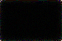

In [51]:
Image.fromarray(new_image)

In [52]:
counter[0, 0]

array([1, 1, 1], dtype=uint8)

In [53]:
counter[-1, -1]

array([1, 1, 1], dtype=uint8)

In [55]:
counter[20, 20]

array([49, 49, 49], dtype=uint8)